In [20]:
import qiskit
import qiskit.quantum_info
import qiskit.visualization

import math

# 0. Some auxiliary functions and class:

In [21]:
def flatten_list (list_of_lists):
    flat_list = []
    for l in list_of_lists:
        flat_list.extend(l)
    return flat_list

def phase_and (qc, input_qbits):
    g = qiskit.circuit.library.ZGate()
    g = g.control(len(input_qbits)-1)
    qc.append(g,input_qbits)

def get_qbits_qc (qc):
    return set(qc.qubits) - set(qc.ancillas)

def add_diffuser(qc, q_registers): 
    for i in q_registers:
        qc.h(i)
        qc.x(i)
    phase_and(qc, q_registers) # multi-control-Z
    for i in q_registers:
        qc.x(i)
        qc.h(i)
    return qc

class C_Counter:
    def __init__(self, trigger_qbits, counter_qbits, qc):
        self.__current_pos=1
        self.__next_jump=1
        self.__n_ccx=1
        self.__triggers=trigger_qbits
        self.__counters=counter_qbits
        self.__is_exhausted = False # have all counter_qbits been generated for this counter?
        self.__n_available_cnt=2**len(counter_qbits)
        self.__exhausted_qc=0
        self.__qc=qc.copy_empty_like()

    def next(self):
        if self.__is_exhausted : 
            return self.__exhausted_qc
        tmp=self.__qc.copy_empty_like()
        for i in range(self.__n_ccx, 0, -1) :
            list_controls=flatten_list([self.__triggers, self.__counters[:i-1]])
            tmp.mcx(control_qubits=list_controls, target_qubit=self.__counters[i-1])
        self.__n_available_cnt-=1
        if self.__current_pos == self.__next_jump :
            self.__current_pos = 1
            self.__next_jump *= 2
            self.__n_ccx += 1
        else :
            self.__current_pos += 1
        if self.__n_available_cnt==1 :
            self.__is_exhausted = True
            self.__exhausted_qc = tmp
        return tmp
    
    def is_exhausted (self):
        return self.__is_exhausted

# 1. Creation of half-oracle for multi-unary codification scheme



In [22]:
def new_oracle (oracle, node0, node1, node2, node3, node4, node5, ancillas):
    edges=[(node4, node0), (node0, node1), (node1, node3), (node1, node2), (node2, node3), (node2, node5)]
    cnt = C_Counter ([ancillas[0]], ancillas[1:], oracle)   
    
    for n in [node0, node1, node2, node3, node4, node5]:
        oracle.x(n)
        oracle.mcx(n, ancillas[0])
        oracle.compose(cnt.next(), inplace=True)
        oracle.mcx(n, ancillas[0])
        oracle.x(n)
        oracle.barrier()
    for e in edges:
        for c in range(3):
            oracle.ccx(e[0][c], e[1][c], ancillas[0])
            oracle.compose(cnt.next(), inplace=True)
            oracle.ccx(e[0][c], e[1][c], ancillas[0])


def create_half_oracle():
    node0=qiskit.circuit.QuantumRegister(3, '0')
    node1=qiskit.circuit.QuantumRegister(3, '1')
    node2=qiskit.circuit.QuantumRegister(3, '2')
    node3=qiskit.circuit.QuantumRegister(3, '3')
    node4=qiskit.circuit.QuantumRegister(3, '4')
    node5=qiskit.circuit.QuantumRegister(3, '5')
    ancillas=qiskit.circuit.AncillaRegister(6, 'a') 
    h_oracle = qiskit.QuantumCircuit(node0, node1, node2, node3, node4, node5, ancillas)
    new_oracle(h_oracle, node0, node1, node2, node3, node4, node5, ancillas)
    h_oracle.barrier()
    h_oracle.x(ancillas[1:])
    return h_oracle

### Depicting the quantum circuit of the half-oracle:

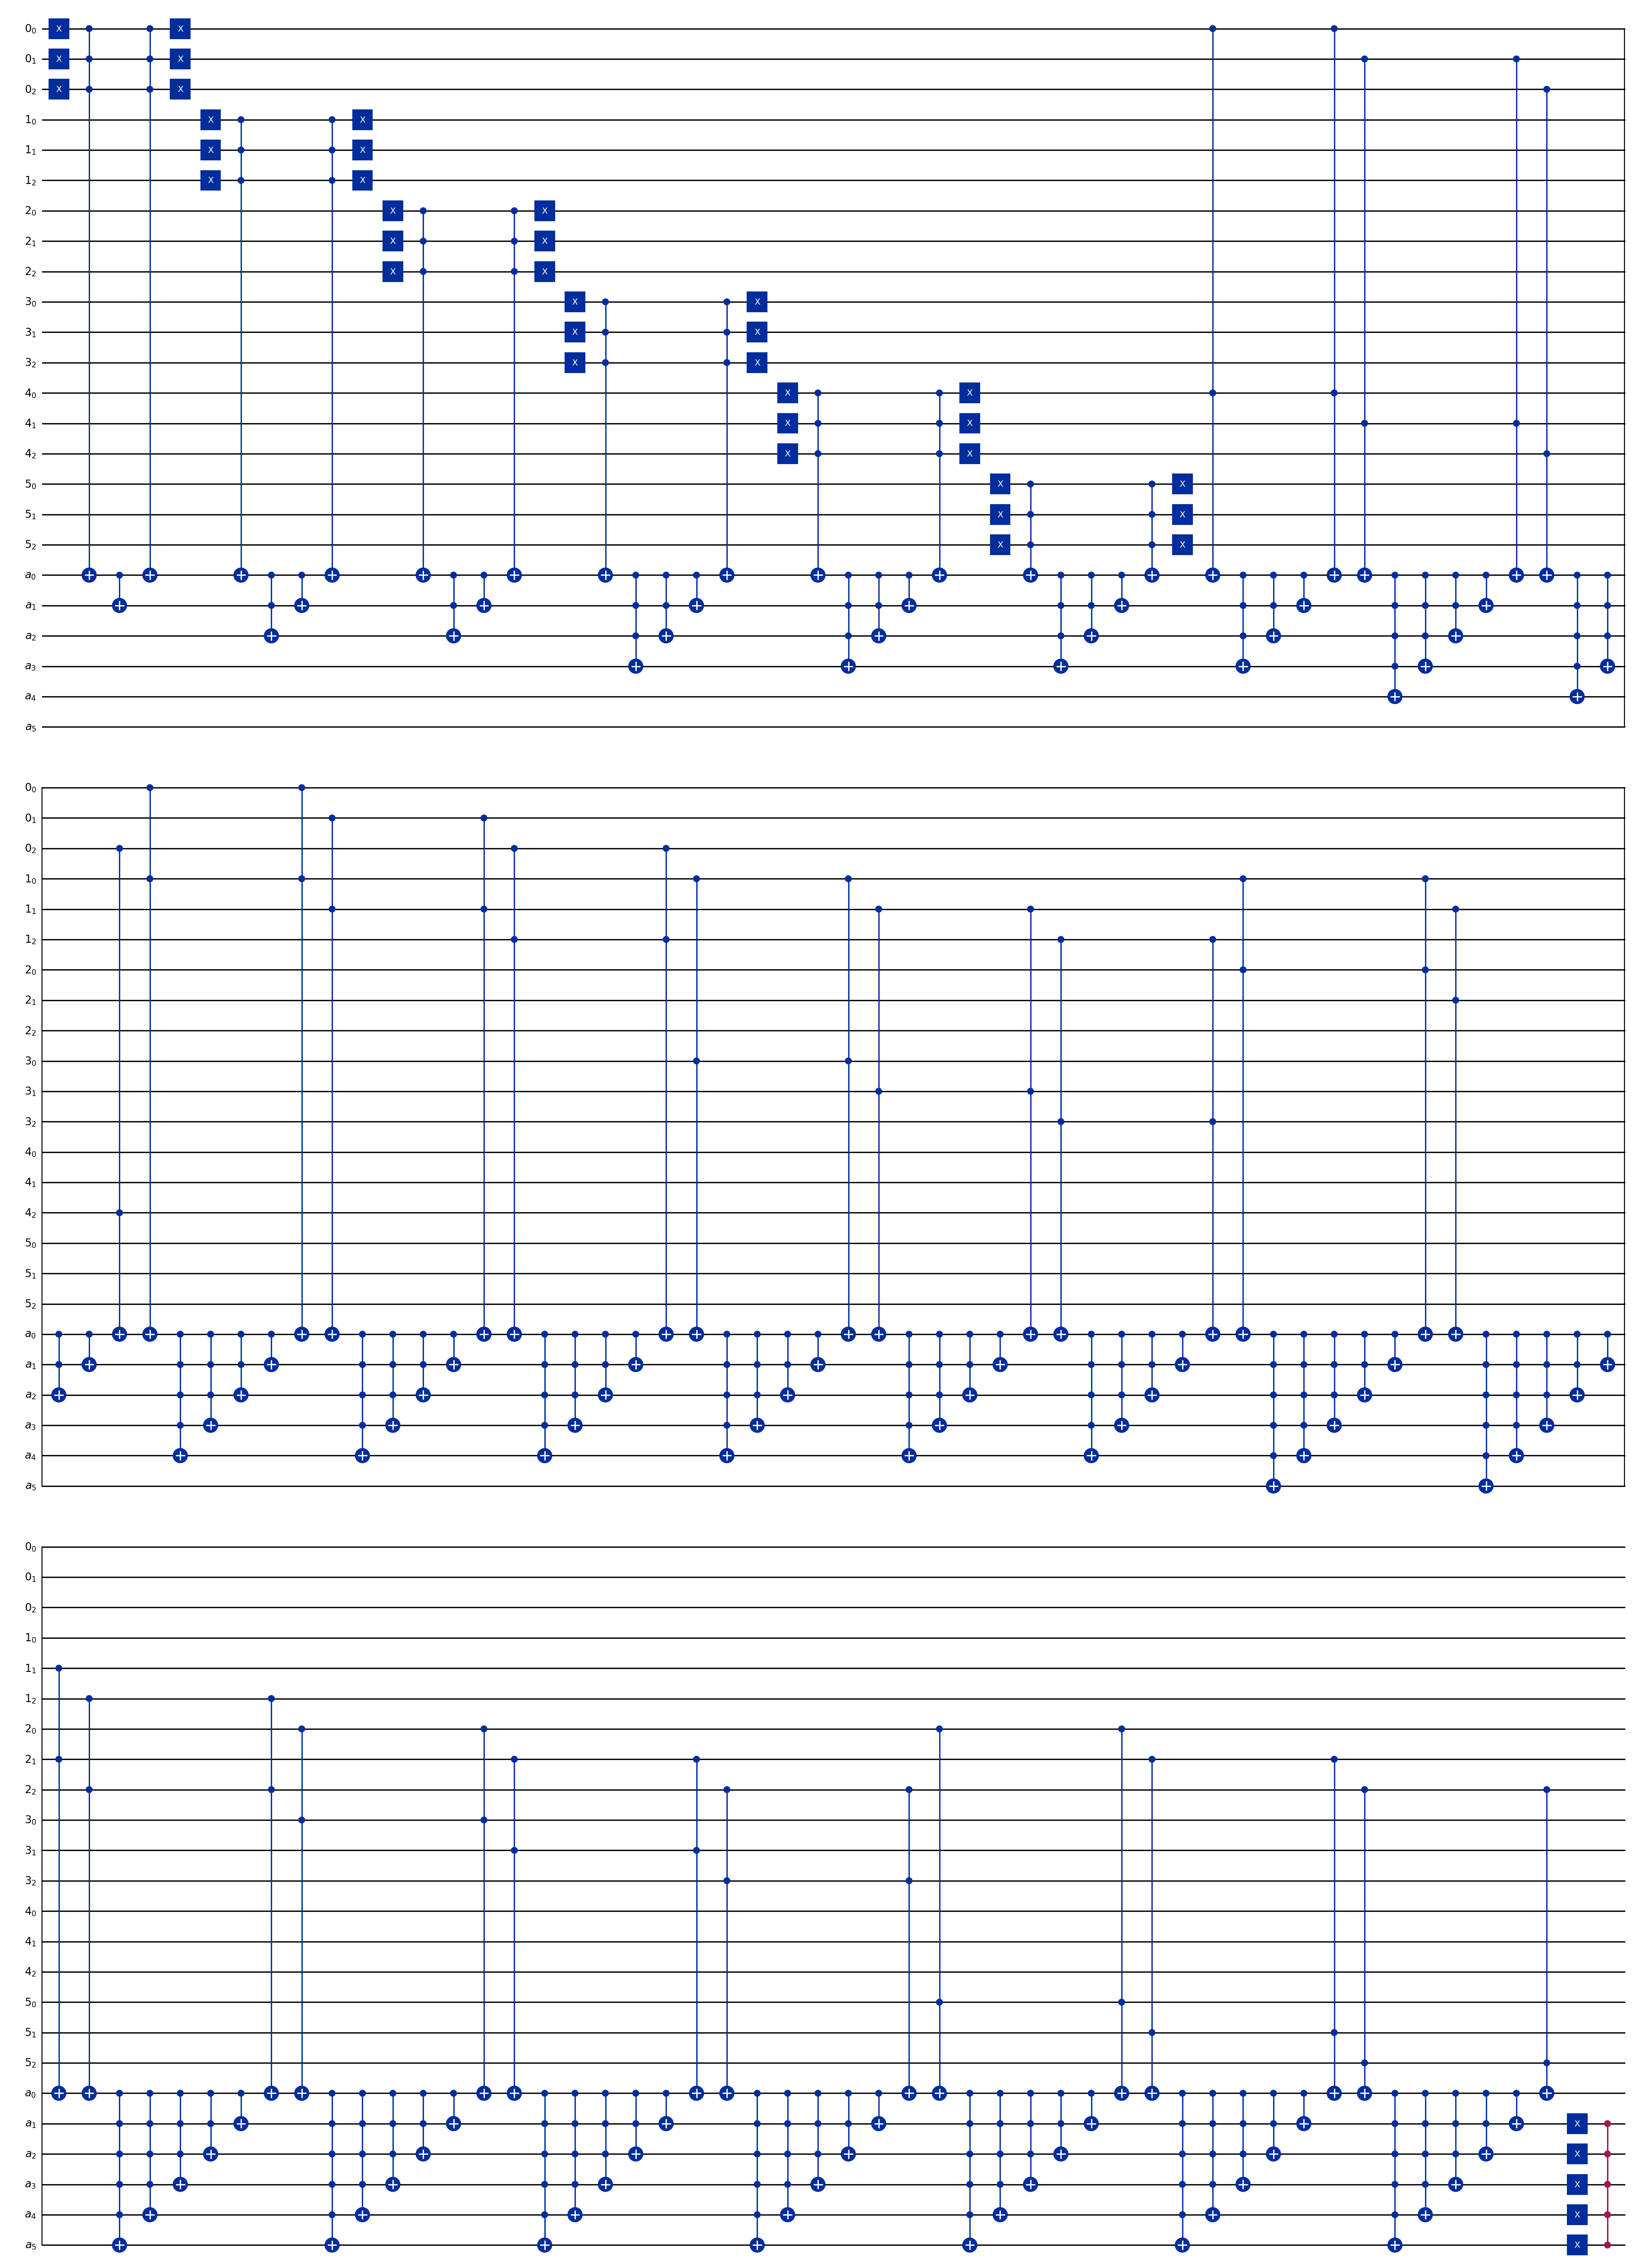

In [23]:
def depict_half_oracle():
    h_oracle = create_half_oracle()
    phase_and(h_oracle, h_oracle.ancillas[1:])
    return h_oracle

depict_half_oracle().draw(output="mpl", fold=52, plot_barriers=False)

# 2. Complete Grover Circuit

In [24]:
def create_complete_oracle():
    h_oracle = create_half_oracle()
    h_oracle_undo = h_oracle.copy().reverse_ops()
    h_oracle.barrier()
    phase_and(h_oracle, h_oracle.ancillas[1:])
    h_oracle.barrier()
    h_oracle.compose(h_oracle_undo, inplace=True)
    return h_oracle

def create_circuit():
    oracle = create_complete_oracle()
    circuit = oracle.copy_empty_like()
    node_qbits = get_qbits_qc(oracle)
    for j in node_qbits:    circuit.h(j)
    oracle.barrier()
    add_diffuser(oracle, get_qbits_qc(oracle))
    circuit.compose(oracle, inplace=True)
    return circuit
    


### Depicting the complete quantum circuit:

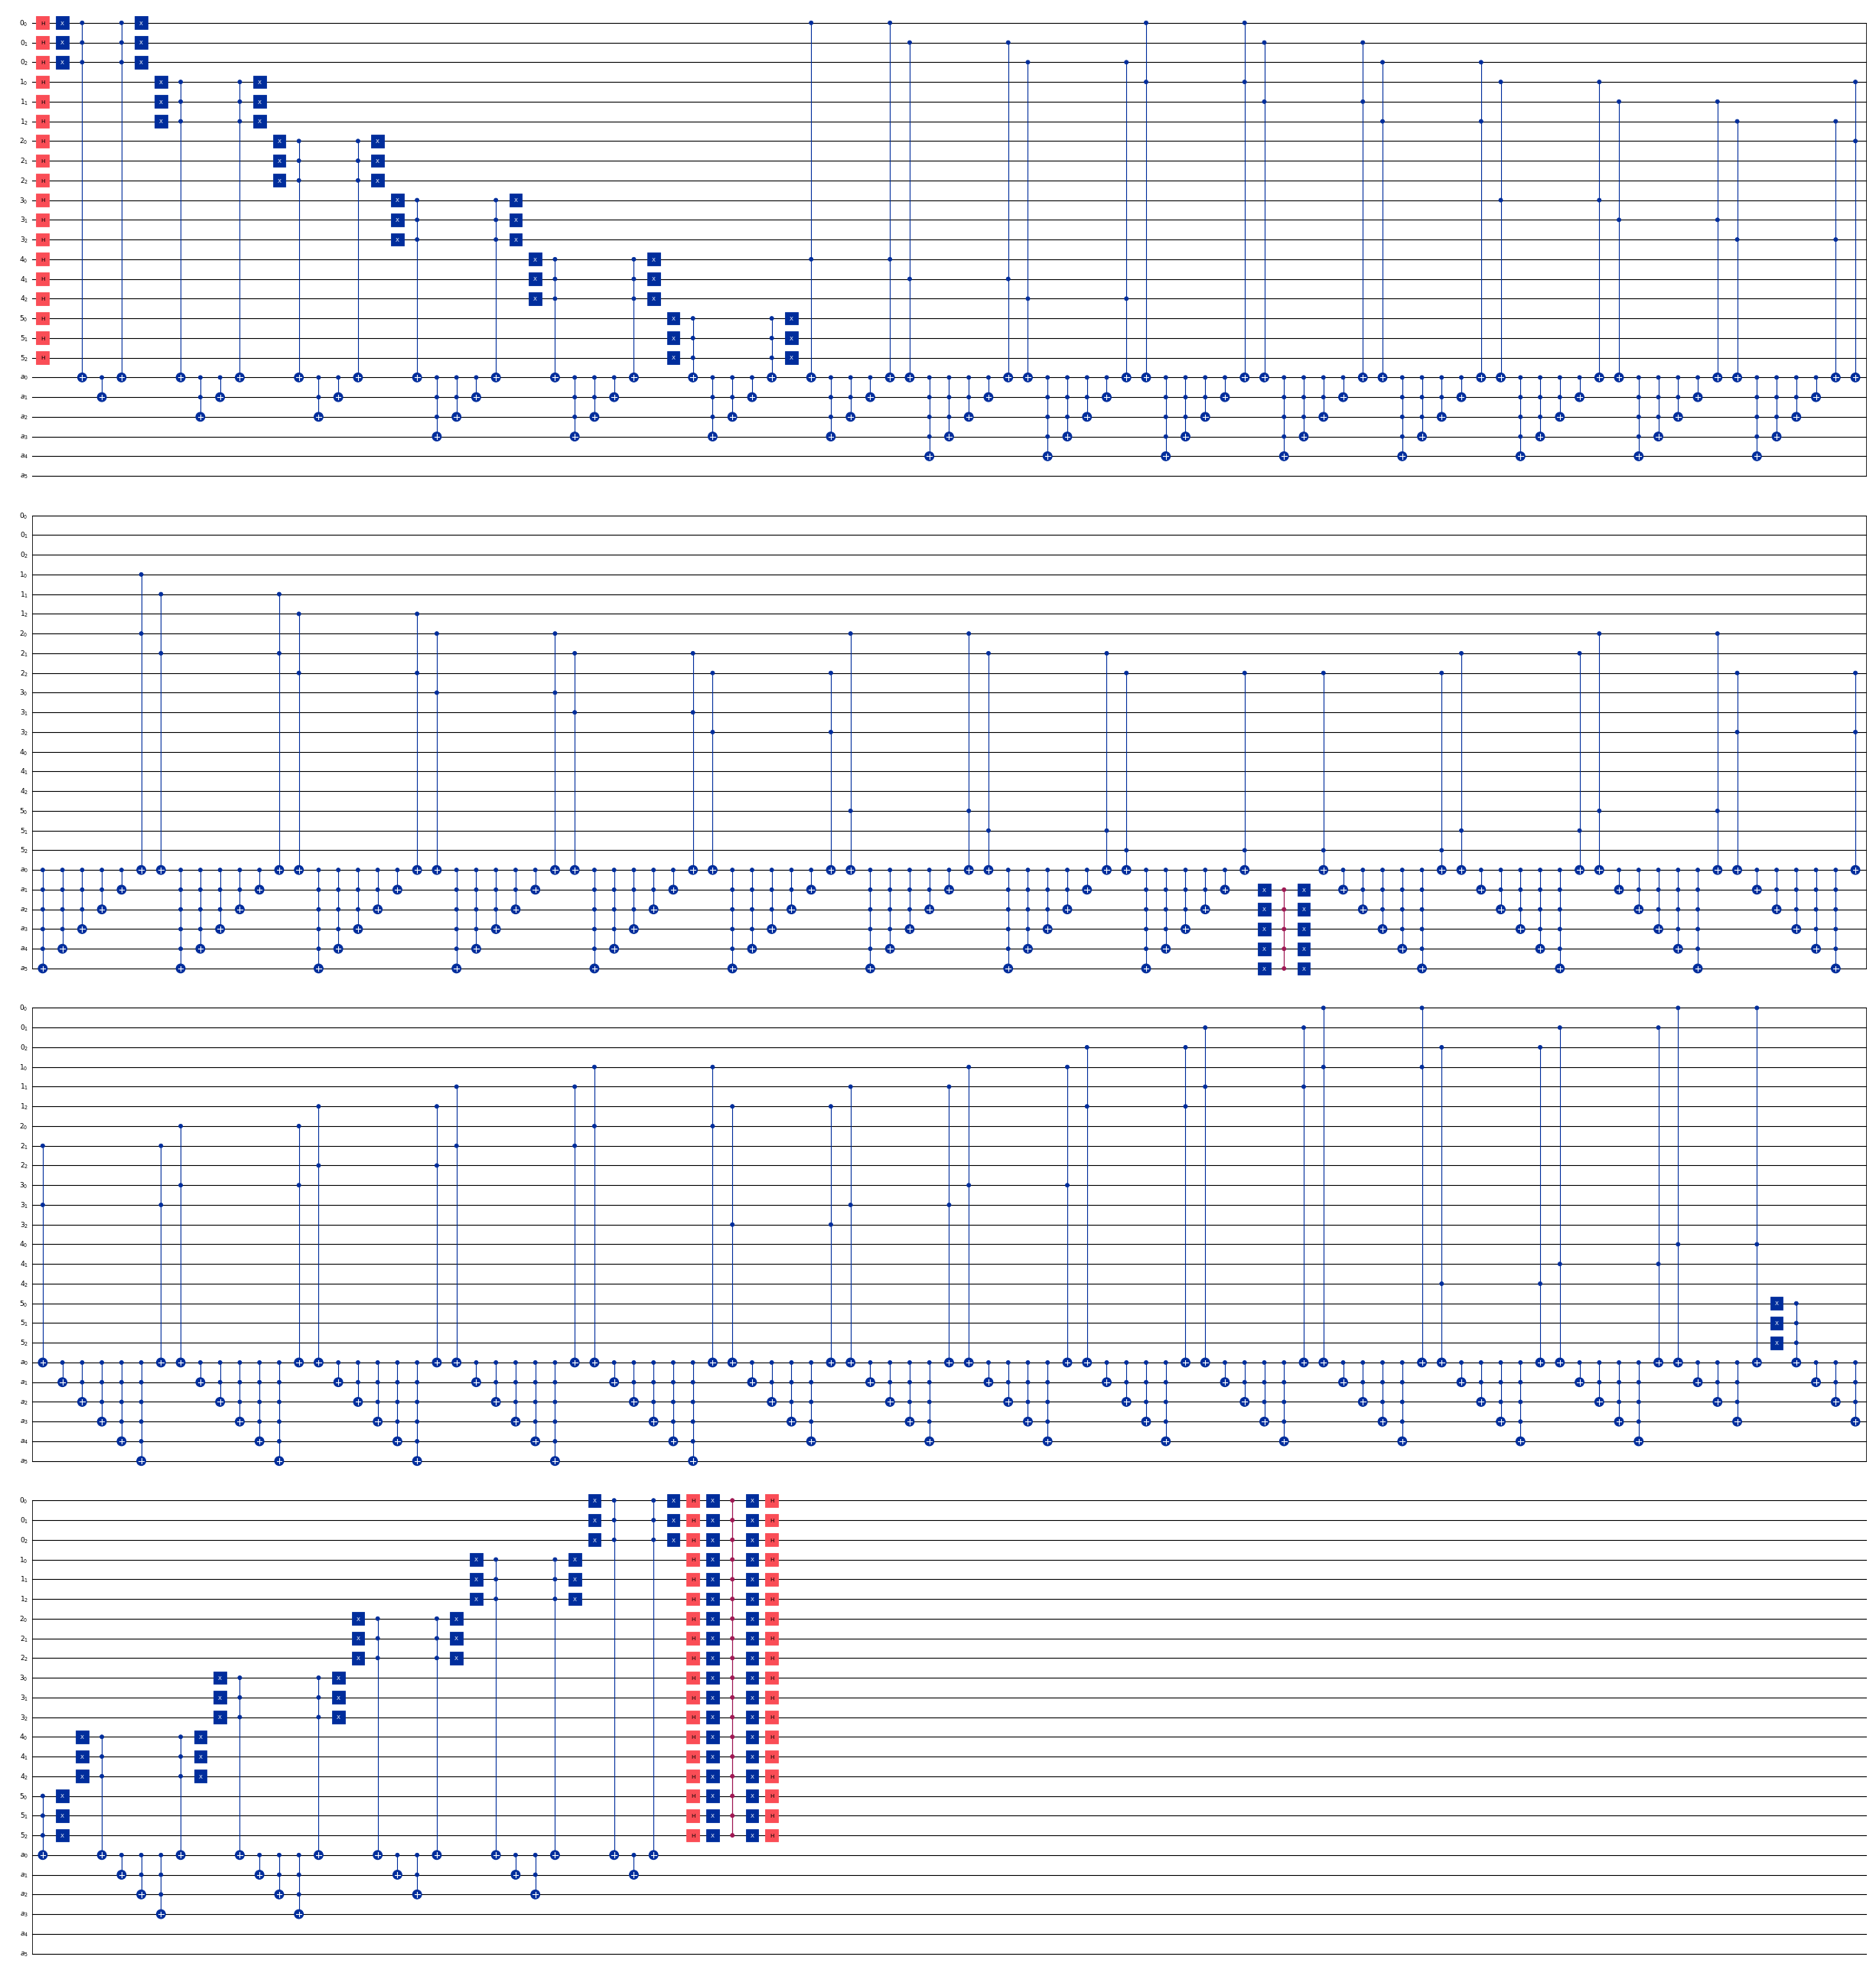

In [25]:
create_circuit().draw(output="mpl", plot_barriers=False, scale=0.4, fold=93)

In [ ]:
stGrover = qiskit.quantum_info.Statevector(create_circuit())